**IBRES Maxime - M2 SIGMA** | Série temporelle : **Bretagne 24-25** |  Date de rendue : **30 Janvier 2026**

---

# === Importation des librairies utiles au projet ===

In [1]:
# 1. CONFIGURATION DU NOTEBOOK
# Rechargement automatique des modules externes
%load_ext autoreload
%autoreload 2

# 2. IMPORTATIONS STANDARD & SYSTÈME
import os
import sys
import time

# Ajout du chemin parent pour trouver les librairies locales
sys.path.append("..")

# 3. LIBRAIRIES SCIENTIFIQUES & GÉOSPATIALES
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from osgeo import gdal

# 4. MACHINE LEARNING (SCIKIT-LEARN)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# 5. LIBRAIRIES PERSONNELLES
from libsigma import read_and_write as rw
from libsigma import plot_confusion_matrix as pcm
from libsigma import plots
# Fonctions spécifiques à ce projet
import my_function as mf

# === Configuration ===

## --- Chemins ---

In [2]:
# == Dossier de travail ==
dir_path = "/home/onyxia/work"

# == Dossier des données ==
data_path = os.path.join(dir_path, "data/projet_eval")

# == Les données ==

# Les échantillons de photointerprétation
shp_path = os.path.join(data_path, "PI_strates_bretagne_32630.shp")

# Les série temporelle d’images Sentinel-2
path_B02 = os.path.join(data_path, "bretagne_24-25_B02.tif")
path_B03 = os.path.join(data_path, "bretagne_24-25_B03.tif")
path_B04 = os.path.join(data_path, "bretagne_24-25_B04.tif")
path_B05 = os.path.join(data_path, "bretagne_24-25_B05.tif")
path_B08 = os.path.join(data_path, "bretagne_24-25_B08.tif")
path_B8A = os.path.join(data_path, "bretagne_24-25_B8A.tif")
path_B11 = os.path.join(data_path, "bretagne_24-25_B11.tif")
path_B12 = os.path.join(data_path, "bretagne_24-25_B12.tif")

# == Les résultats ==

# Dossier des cartes
result_path = os.path.join(dir_path, "results")
os.makedirs(result_path, exist_ok=True)
# Chemin des cartes
path_output_nari = os.path.join(result_path, 'ARI_serie_temp.tif')
output_map_path = os.path.join(result_path, 'carte_strates.tif')

# Dossier des figures
figure_path = os.path.join(result_path, "figure")
os.makedirs(figure_path, exist_ok=True)
# Chemins des figures
diag_nb_poly_path = os.path.join(figure_path, "diag_baton_nb_poly_by_class.png")
diag_nb_pix_path = os.path.join(figure_path, "diag_baton_nb_pix_by_class.png")
path_output_nari_series = os.path.join(figure_path, "ARI_series.png")
path_matrix = os.path.join(figure_path, "matrice_confusion.png")
path_quality = os.path.join(figure_path, "qualite_by_class.png")

## --- Données de travail ---

### ➥ Nomenclatures des strates

In [3]:
CLASSES_INFO = {
    1: {'label': 'Sol Nu', 'color': 'lightgray'},
    2: {'label': 'Herbe', 'color': 'yellowgreen'},
    3: {'label': 'Landes', 'color': 'sandybrown'},
    4: {'label': 'Arbre', 'color': 'forestgreen'}
}

# Extraction automatique pour les graphes
LABELS_LIST = [v['label'] for k, v in CLASSES_INFO.items()]
LABELS_DICT = {k: v['label'] for k, v in CLASSES_INFO.items()}
COLORS_LIST = [v['color'] for k, v in CLASSES_INFO.items()]
NAME_TO_COLOR = {v['label']: v['color'] for k, v in CLASSES_INFO.items()}
clean_labels = ['Herbe', 'Landes', 'Arbre']

### ➥ Échantillons obtenues par photo interprétation

In [4]:
gdf = gpd.read_file(shp_path)
label_strates = 'strate'
print(f"Nombre total d'échantillons chargés : {len(gdf)}")
display(gdf.head())

Nombre total d'échantillons chargés : 278


,id,strate,comment,geometry
0,1,3,lande basse,"POLYGON ((441224.58 5366298.317, 441224.779 53..."
1,2,3,lande basse,"POLYGON ((441649.972 5366251.139, 441650.172 5..."
2,3,3,lande basse,"POLYGON ((441383.597 5366193.034, 441384.395 5..."
3,4,2,None,"POLYGON ((441336.658 5366402.088, 441337.257 5..."
4,5,2,None,"POLYGON ((441062.121 5366343.165, 441062.919 5..."


## --- Bug sur les graphiques ---

In [5]:
# Désactive LaTeX pour tout le reste du notebook (= PBM avec fonction de matrice de confusion)
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'sans-serif'
})
print("Configuration Matplotlib réparée : LaTeX désactivé.")

Configuration Matplotlib réparée : LaTeX désactivé.


# === Analyse des échantillons ===

In [6]:
# A. Nombre de polygones
# value_counts compte les occurrences, sort_index remet les classes 1, 2, 3, 4 dans l'ordre
serie_poly = gdf[label_strates].value_counts().sort_index()

# B. Nombre de pixels
# Sentinel-2 a une résolution de 10m (1 pixel = 100m²)
gdf['pixels_estimes'] = gdf.geometry.area / 100
serie_pix = gdf.groupby(label_strates)['pixels_estimes'].sum()

# C. Application des labels pour l'affichage
serie_poly.index = serie_poly.index.map(LABELS_DICT)
serie_pix.index = serie_pix.index.map(LABELS_DICT)

## --- Tableau récapitulatif bilan ---

In [7]:
df_recap = pd.DataFrame({
    'Nb Polygones': serie_poly,
    'Nb Pixels (est.)': serie_pix
})

total_poly = df_recap['Nb Polygones'].sum()
total_pix = df_recap['Nb Pixels (est.)'].sum()

df_recap['% Polygones'] = (df_recap['Nb Polygones'] / total_poly) * 100
df_recap['% Pixels'] = (df_recap['Nb Pixels (est.)'] / total_pix) * 100

row_total = pd.DataFrame({
    'Nb Polygones': [total_poly], 
    'Nb Pixels (est.)': [total_pix],
    '% Polygones': [100.0],
    '% Pixels': [100.0]
}, index=['TOTAL'])

df_recap_final = pd.concat([df_recap, row_total])

display(df_recap_final.style.format({
    'Nb Polygones': '{:.0f}',
    'Nb Pixels (est.)': '{:,.0f}',
    '% Polygones': '{:.2f} %',
    '% Pixels': '{:.2f} %'
}))

,Nb Polygones,Nb Pixels (est.),% Polygones,% Pixels
Herbe,86,"1,075",30.94 %,27.58 %
Landes,121,"1,602",43.53 %,41.08 %
Arbre,71,"1,222",25.54 %,31.34 %
TOTAL,278,"3,899",100.00 %,100.00 %


## --- Graphiques ---

In [8]:
# 1. Préparation des couleurs
colors_poly = [NAME_TO_COLOR[label] for label in serie_poly.index]
colors_pix = [NAME_TO_COLOR[label] for label in serie_pix.index]

In [9]:
# 2. Sauvegarde des résultats
mf.save_class_distributions(
    serie_poly, serie_pix, 
    colors_poly, colors_pix, 
    diag_nb_poly_path, diag_nb_pix_path
)

=> Graphique sauvegardé dans /home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.png.
=> Graphique sauvegardé dans /home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.png.


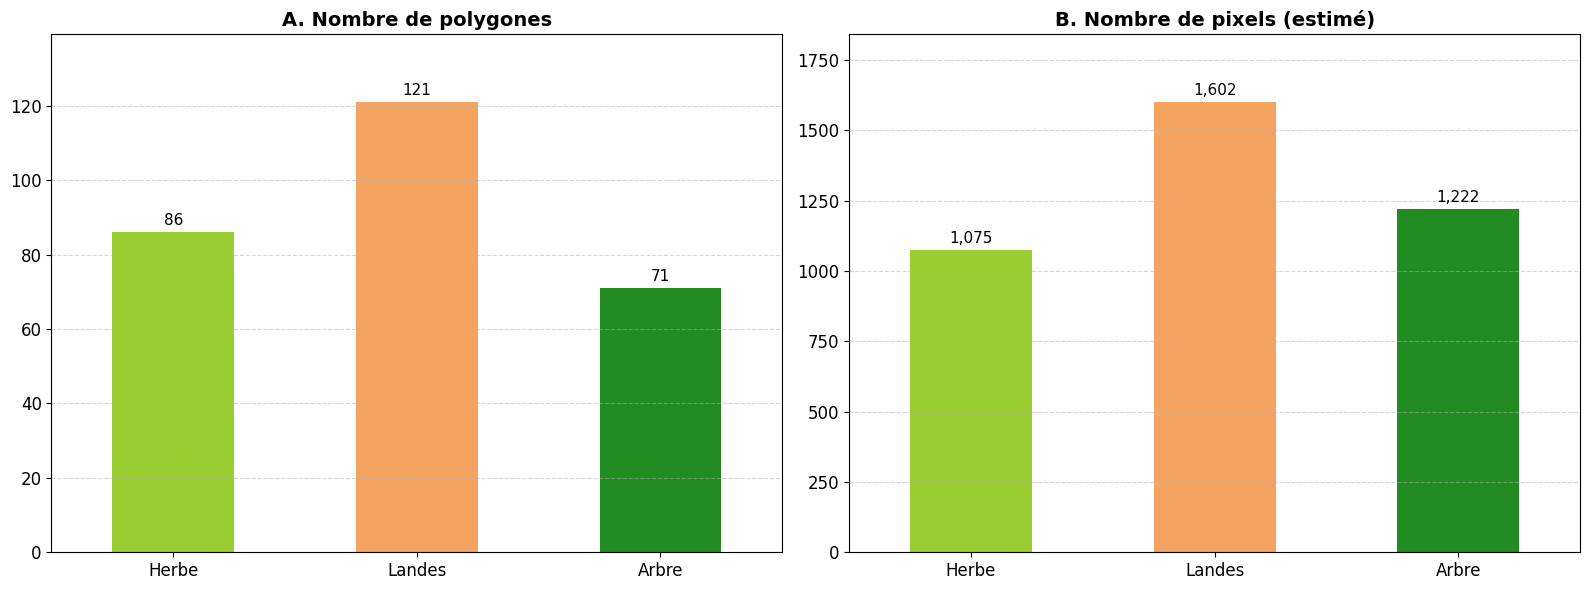

In [10]:
# 3. Affichage dans le notebook (Figure double)
mf.show_class_distributions(
    serie_poly, serie_pix, 
    colors_poly, colors_pix
)

On observe une prédominance de la classe "Landes", à la fois en nombre de polygones et en nombre de pixels. C'est intéressant car c'est la classe cible principale de l'étude (pour la mise en évidence des éricacées). Les classes "Herbe" et "Arbre" sont moins représentées mais restent dans un ordre de grandeur comparable. Aucun polygone de la classe "Sol Nu" n'est présent dans le fichier d'échantillons.

## === Phénologie des strates (mise en évidence des landes) ===

Nous allons calculer l'indice NARI (Normalized Anthocyanin Reflectance Index) pour mettre en évidence la présence de pigments rouges (anthocyanes) caractéristiques des landes (Ericaceae) en période de stress ou de floraison.

**Formule utilisée :**
$$ARI = \frac{\\1/B03 - \\1/B05}{\\1/B03 + \\1/B05}$$

## --- Calcul de l'indice NARI et Sauvegarde ---

In [11]:
# 1. Chargement
arr_b03 = rw.load_img_as_array(path_B03)
arr_b05 = rw.load_img_as_array(path_B05)

# 2. Calcul du NARI via votre fonction
nari = mf.compute_nari(arr_b03, arr_b05)

/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Calcul du NARI effectué.


In [12]:
# 3. Sauvegarde
ds_ref = rw.open_image(path_B03) # Pour récupérer la projection
rw.write_image(
    out_filename=path_output_nari,
    array=nari,
    data_set=ds_ref,
    gdal_dtype=gdal.GDT_Float32,
    driver_name="GTiff"
)

# 4. Ajout du tag NoData (via la fonction helper)
mf.add_nodata_metadata(path_output_nari, nodata_value=-9999)

print(f"=> Fichier NARI généré et tagué : {path_output_nari}")

=> Fichier NARI généré et tagué : /home/onyxia/work/results/ARI_serie_temp.tif


## --- Analyse temporelle ---

Les valeurs mathématiques de l'indice ARI sont bien dans le fichier ARI_serie_temp.tif MAIS ce fichier est "aveugle". Il contient des millions de pixels avec des valeurs, mais il ne sait pas ce que ces pixels représentent. Pour lui, un pixel de lande ou un pixel d'herbe, c'est juste un chiffre à une coordonnée (x, y). Nous croisons donc la série temporelle d'ARI produite avec les échantillons de terrain (polygones = shape) pour extraire la signature moyenne de chaque strate.

### ➥ Extraction des statistiques par classe

In [13]:
# 1. Vos dates (Donnée)
dates_str = [
    '2025-03-31', '2025-04-10', '2025-05-15', 
    '2025-06-17', '2025-07-12', '2025-08-10'
]
dates = pd.to_datetime(dates_str)

# 2. Chargement de l'image (Donnée)
ari_cube = rw.load_img_as_array(path_output_nari).astype('float32')
ari_cube[ari_cube == -9999] = np.nan

# 3. Rastérisation des échantillons
mask_classes = mf.rasterize_samples(
    image_ref_path=path_output_nari, 
    vector_path=shp_path, 
    field_name='strate'
)

# 4. Calcul des stats
stats_results = mf.extract_temporal_stats(
    ari_cube=ari_cube, 
    mask_classes=mask_classes, 
    classes_info=CLASSES_INFO
)

### ➥ Génération du graphique

=> Graphique sauvegardé : /home/onyxia/work/results/figure/ARI_series.png


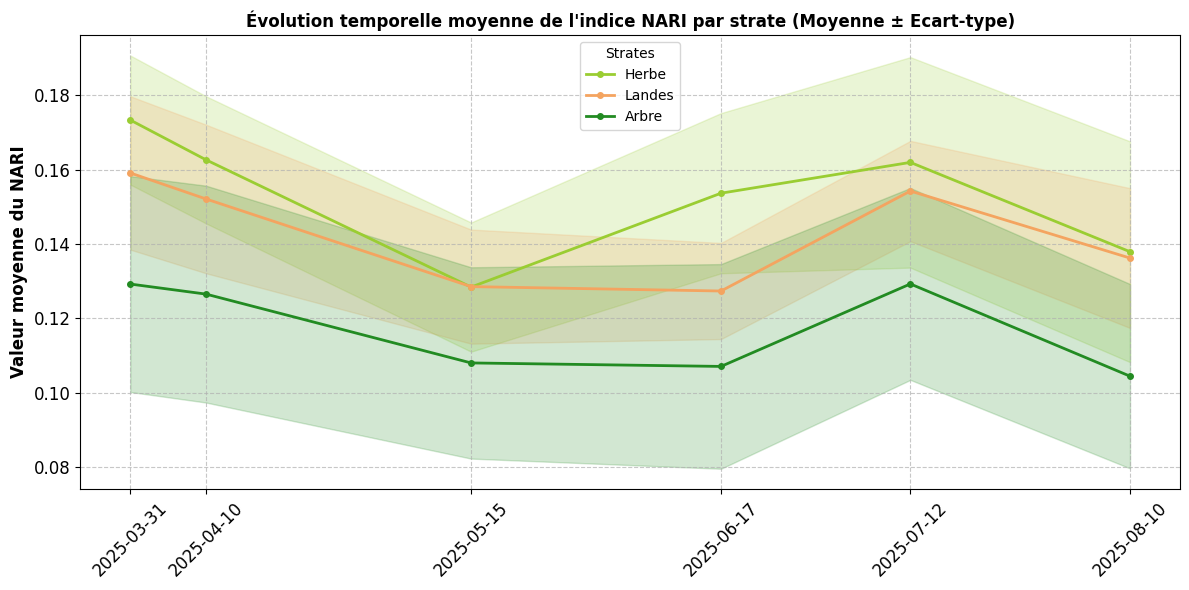

In [14]:
mf.plot_nari_series(
    stats_dict=stats_results, 
    dates=dates, 
    out_filename=path_output_nari_series
)

In [15]:
del mask_classes
del ari_cube

# === Production d’une carte de strates à l’échelle du pixel ===

## --- Préparation de la Matrice X (Features) et du Vecteur Y (Labels) ---

In [16]:
# 1. Liste de TOUTES les images à utiliser (Features)
input_files = [
    # Bandes brutes (Séries Temporelles)
    path_B02, path_B03, path_B04, path_B05, 
    path_B08, path_B8A, path_B11,path_B12,
    # Indice ARI calculé (Feature Engineering)
    path_output_nari
]

In [17]:
# 2. Récupère X, Y (pour l'entrainement) ET X_full (pour la carte finale)
X, Y, X_full = mf.prepare_training_dataset(
    list_files=input_files, 
    shp_path=shp_path, 
    field_name='strate'
)

--- Préparation du Dataset d'entraînement ---
Chargement de 9 fichiers...
 -> Ajouté : bretagne_24-25_B02.tif (6 dates)
 -> Ajouté : bretagne_24-25_B03.tif (6 dates)
 -> Ajouté : bretagne_24-25_B04.tif (6 dates)
 -> Ajouté : bretagne_24-25_B05.tif (6 dates)
 -> Ajouté : bretagne_24-25_B08.tif (6 dates)
 -> Ajouté : bretagne_24-25_B8A.tif (6 dates)
 -> Ajouté : bretagne_24-25_B11.tif (6 dates)
 -> Ajouté : bretagne_24-25_B12.tif (6 dates)
 -> Ajouté : ARI_serie_temp.tif (6 dates)
Dataset, X (Tab. variables) et Y (Tab. classes) extraits.


In [18]:
# 3. Affichage du Bilan 
mf.print_X_Y_matrix_bilan(X, Y, X_full)


                 BILAN DES DONNÉES D ENTRÉE                 

1. RÉALITÉ TERRAIN (X_full) -> Pour la Carte Finale
   • Structure  : CUBE 3D (Lignes, Colonnes, Variables)
   • Dimensions : (612, 1533, 54)
   • Surface    : 938 196 pixels totaux
   • Variables  : 54
------------------------------------------------------------
2. JEU D'ENTRAÎNEMENT (X, Y) -> Pour le Modèle
   • Structure  : TABLEAU 2D (Échantillons, Variables)
   • Dimensions X : (3839, 54)
   • Dimensions Y : (3839,)
   • Échantillons : 3 839 pixels annotés
------------------------------------------------------------
3. ANALYSE DU RATIO
   => Le modèle apprend sur 0.409% de la zone totale.
   => COHÉRENCE OK : 54 variables de part et d'autre.



## --- Choix du classifieur et sa paramètrisation ---

### ➥ Train/Test split --> (70%)/(30%)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=0 
)

print(f" -> Données d'entraînement : {X_train.shape[0]} pixels")
print(f" -> Données de test : {X_test.shape[0]} pixels")

 -> Données d'entraînement : 2687 pixels
 -> Données de test : 1152 pixels


### ➥ Définition du modèle et de la grille

In [20]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 5]
}

### ➥ Cross-validation stratifiée

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### ➥ Grille de recherche = GridSearchCV

In [26]:
print("Lancement de l'optimisation (GridSearchCV)...")

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

# Entraînement avec recherche des meilleurs hyperparamètres (Sur le TRAIN seulement)
grid.fit(X_train, y_train)

print(f"Optimisation terminée.")

Lancement de l'optimisation (GridSearchCV)...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   8.9s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   9.3s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   9.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   9.8s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  10.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  14.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  15.9s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  16.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total 

KeyboardInterrupt: 

### ➥ Résultats de l'optimisation

In [25]:
# Affichage des courbes d'impact (GridSearch)
mf.plot_hyperparam_impact(grid.cv_results_)

NameError: name 'grid' is not defined

In [ ]:
# Extraction du modèle final (celui avec les meilleurs paramètres)
best_rf = grid.best_estimator_

# Affichage pour vérification
print("Meilleurs paramètres trouvés")
df_params = pd.DataFrame(list(grid.best_params_.items()), columns=['Hyperparamètre', 'Optimisé'])
display(df_params.style.hide(axis='index'))
print(f"Meilleur score CV => {grid.best_score_:.4f}")

Meilleurs paramètres trouvés


NameError: name 'grid' is not defined

In [ ]:
# Affichage de la combinaison d'hyperparamètres optimisée + score
print(f"Score CV moyen de la combinaison optimisée : {grid.best_score_:.4f}")


La combinaison optimale retenue par le GridSearch (grid.best_params_) correspond exactement à la réunion des optimums locaux de chaque hyperparamètres comme vu sur les graphiques de la précision moyenne de chaque cas.

### ➥ Evaluation sur le test (La vérité terrain)

In [ ]:
y_pred = best_rf.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print(f"Accuracy test : {acc_test:.4f}")

In [ ]:
# Nettoyage
del grid

## --- Stratégie de validation : importance des variables ---

In [ ]:
df_importance = mf.compute_feature_importance(
    model=best_rf, 
    file_list=input_files, 
    dates_list=dates_str
)

### ➥ Les 10 variables qui expliquent le mieux le modèle

In [ ]:
# Affichage textuel des 10 premières variables
print(f"Somme des importances : {df_importance['Importance'].sum():.0f}") # Vérification
print("\n=== TOP 10 VARIABLES LES PLUS IMPORTANTES ===")
display(df_importance.head(10).style.hide(axis='index'))

In [ ]:
# Affichage du graphique
mf.plot_top_features(df_importance, top_n=10)

## --- Production des cartes finales ---

In [ ]:
mf.generate_final_map(
    model=best_rf, 
    X_full=X_full,
    ref_image_path=input_files[0],
    out_path=output_map_path,
    nodata=0
)

In [ ]:
# Affichage de la carte finale
mf.show_classification_map(
    map_path=output_map_path, 
    classes_info=CLASSES_INFO,
    title="Classification des Strates - Bretagne 2024/2025"
)

## --- Analyse des résultats ---

In [ ]:
# Calcul des métriques nécessaires
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)


In [ ]:
# Graphique 1 : Matrice de Confusion
plots.plot_cm(
    cm=cm, 
    labels=clean_labels,
    out_filename=path_matrix,
    normalize=False
)
print(f"=> Figure sauvegardée dans : {path_matrix}")

In [ ]:
# 4. Graphique 2 : Qualité par Classe (Bâtons)
# Le rapport doit être sous forme de DICTIONNAIRE pour que la fonction puisse le lire
report = classification_report(y_test, y_pred, target_names=clean_labels, output_dict=True)
plots.plot_class_quality(
    report=report, 
    accuracy=accuracy, 
    out_filename=path_quality
)
print(f"=> Figure sauvegardée dans : {path_quality}")

# === Discussions ===